In [31]:
import torch
from Loader_17 import DAVIS_Rawset, DAVIS_Infer, DAVIS_Dataset, normalize
from polygon import RasLoss, SoftPolygon
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import copy
import matplotlib.pyplot as plt
from einops import rearrange
import torch.nn.functional as F
from MyLoss import deviation_loss, total_len_loss
from torch.nn.init import xavier_uniform_
from ms_deform_attn import MSDeformAttn
from torch.utils.data import Dataset
import json
import random
import gc
import regex as re
from deform_video import (
    DAVIS_withPoint,
    DeformVideo,
    VideoInferer,
    PositionalEncoding,
    DeformableTransformerEncoderLayer,
    DeformableTransformerDecoderLayer,
    DeformableTransformerEncoder,
    DeformableTransformerDecoder,
    DeformableTransformerExtraDecoderLayer,
    DeformableTransformerExtraDecoder,
    MLP,
    get_valid_ratio,
)
from deform_model import get_batch_average_bou_iou
import math

In [2]:
train_rawset = DAVIS_Rawset(is_train=True)
val_rawset = DAVIS_Rawset(is_train=False)

In [3]:
train_dataset = DAVIS_withPoint(
    train_rawset,
    is_train=True,
    point_num=64,
)
val_dataset = DAVIS_withPoint(
    val_rawset,
    is_train=False,
    point_num=64,
)

In [44]:
short_train_rawset = copy.copy(train_rawset)
short_train_rawset.data_set = train_rawset.data_set[:5]
short_train_dataset = DAVIS_withPoint(
    short_train_rawset,
    point_num=64,
    is_train=True,
)
len(short_train_dataset.raw_data_set)

3

In [52]:
short_val_rawset = copy.copy(val_rawset)
short_val_rawset.data_set = val_rawset.data_set[:2]
short_val_dataset = DAVIS_withPoint(
    short_val_rawset,
    point_num=64,
    is_train=False,
)
len(short_val_dataset.raw_data_set)

2

In [51]:
short_train_loader = DataLoader(
    short_train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4,
)
print(len(short_train_loader))

241


In [90]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4,
)

In [91]:
len(train_data_loader)

7706

In [88]:
# test the train_data_loader
video_idx, frame_idx, first_frame, second_frame, current_frame = next(iter(train_data_loader))

In [4]:
class DeformLightVideo(nn.Module):
    def __init__(
        self,
        layer_num=1,
        head_num=6,
        medium_level_size=[14, 28, 56, 112],
        offset_limit=10,
        n_points=4,
        mem_point_num=64,
        freeze_backbone=True,
    ) -> None:
        super(DeformLightVideo, self).__init__()
        self.offset_limit = offset_limit
        self.n_points = n_points
        self.point_num = mem_point_num
        self.medium_level_size = medium_level_size
        self.featup = torch.hub.load(
            "mhamilton723/FeatUp",
            "dino16",
            use_norm=True,
        )
        if freeze_backbone:
            for param in self.featup.parameters():
                param.requires_grad = False
        d_model = 384
        d_ffn = 1024
        n_levels = len(medium_level_size) + 1
        self.pos_enoc = PositionalEncoding(d_model)

        enc_layer = DeformableTransformerEncoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )
        dec_layer = DeformableTransformerDecoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )

        self.first_query_embed = nn.Embedding(mem_point_num, d_model)
        xavier_uniform_(self.first_query_embed.weight)
        self.first_layer_norm = nn.LayerNorm(d_model)
        self.fir_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        self.fir_dec = DeformableTransformerDecoder(
            dec_layer,
            num_layers=layer_num,
        )
        self.previous_query_embed = nn.Embedding(mem_point_num, d_model)
        xavier_uniform_(self.previous_query_embed.weight)
        self.previous_layer_norm = nn.LayerNorm(d_model)
        self.pre_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        self.pre_dec = DeformableTransformerDecoder(
            dec_layer,
            num_layers=layer_num,
        )
        self.extra_layer_norm = nn.LayerNorm(d_model)

        self.current_query_embed = nn.Embedding(mem_point_num, d_model)
        xavier_uniform_(self.current_query_embed.weight)
        self.current_layer_norm = nn.LayerNorm(d_model)
        self.cur_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        extra_dec_layer = DeformableTransformerExtraDecoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )
        self.cur_dec = DeformableTransformerExtraDecoder(
            extra_dec_layer,
            num_layers=layer_num,
        )
        self.xy_fc = MLP(d_model, d_model, 2, 3)

    def forward(
        self,
        fir_img: torch.Tensor,
        fir_bou: torch.Tensor,
        pre_img: torch.Tensor,
        pre_bou: torch.Tensor,
        pre_sgm: torch.Tensor,
        cur_img: torch.Tensor,
    ):
        fir_bou = fir_bou / 224
        pre_bou = pre_bou / 224
        (
            fir_img_srcs_flatten,
            fir_spatial_shapes,
            fir_level_start_index,
            fir_valid_ratios,
        ) = self._get_enced_img_scrs(
            fir_img,
            self.fir_enc,
            self.first_layer_norm,
        )
        (
            pre_img_srcs_flatten,
            pre_spatial_shapes,
            pre_level_start_index,
            pre_valid_ratios,
        ) = self._get_enced_img_scrs(
            pre_img,
            self.pre_enc,
            self.previous_layer_norm,
        )
        (
            cur_img_srcs_flatten,
            cur_spatial_shapes,
            cur_level_start_index,
            cur_valid_ratios,
        ) = self._get_enced_img_scrs(
            cur_img,
            self.cur_enc,
            self.current_layer_norm,
        )

        B, S, C = fir_img_srcs_flatten.shape
        first_queries = (
            self.first_query_embed.weight.unsqueeze(0).repeat(B, 1, 1).cuda()
        )
        first_memory, _ = self.fir_dec(
            first_queries,
            fir_bou,
            fir_img_srcs_flatten,
            fir_spatial_shapes,
            fir_level_start_index,
            fir_valid_ratios,
        )
        previous_queries = (
            self.previous_query_embed.weight.unsqueeze(0).repeat(B, 1, 1).cuda()
        )
        previous_memory, _ = self.pre_dec(
            previous_queries,
            pre_bou,
            pre_img_srcs_flatten,
            pre_spatial_shapes,
            pre_level_start_index,
            pre_valid_ratios,
        )
        extra_memory = torch.cat([first_memory, previous_memory], 1)
        extra_memory = self.extra_layer_norm(extra_memory)
        extra_memory = self.pos_enoc(extra_memory)

        current_queries = (
            self.current_query_embed.weight.unsqueeze(0).repeat(B, 1, 1).cuda()
        )
        cur_bou = pre_bou
        decode_output, _ = self.cur_dec(
            current_queries,
            cur_bou,
            cur_img_srcs_flatten,
            cur_spatial_shapes,
            cur_level_start_index,
            cur_valid_ratios,
            extra_memory,
        )

        xy_offset = self.xy_fc(decode_output)
        xy_offset = (xy_offset.sigmoid() - 0.5) * self.offset_limit / 224

        result = pre_bou + xy_offset
        result = result * 224
        if not self.training:
            return result.clamp(0, 223)
        return result

    def _get_img_scrs(self, img: torch.Tensor, layernorm: nn.LayerNorm):
        feats = self.featup(img)
        srcs = []
        padding_masks = []
        for low_res in self.medium_level_size:
            srcs.append(
                F.interpolate(
                    feats,
                    size=(low_res, low_res),
                    mode="bilinear",
                ),
            )
        srcs.append(feats)
        for src in srcs:
            padding_masks.append(torch.zeros_like(src[:, 0:1, :, :]).squeeze(1).bool())
        src_flatten = []
        spatial_shapes = []
        for src in srcs:
            src_flatten.append(
                rearrange(src, "b c h w -> b (h w) c"),
            )
            spatial_shapes.append(src.shape[-2:])
        level_start_index = torch.cat(
            (
                torch.tensor([0]),
                torch.cumsum(
                    torch.tensor([x.shape[1] for x in src_flatten]),
                    0,
                )[:-1],
            )
        ).cuda()
        src_flatten = torch.cat(src_flatten, 1).cuda()
        valid_ratios = torch.stack(
            [get_valid_ratio(mask) for mask in padding_masks],
            1,
        ).cuda()
        spatial_shapes = torch.as_tensor(
            spatial_shapes,
            dtype=torch.long,
            device=src_flatten.device,
        )
        src_flatten = layernorm(src_flatten)
        src_flatten = self.pos_enoc(src_flatten)
        return src_flatten, spatial_shapes, level_start_index, valid_ratios

    def _get_enced_img_scrs(
        self,
        img: torch.Tensor,
        encoder: DeformableTransformerEncoder,
        layernorm: nn.LayerNorm,
    ):
        src_flatten, spatial_shapes, level_start_index, valid_ratios = (
            self._get_img_scrs(img, layernorm)
        )
        src_flatten = encoder(
            src=src_flatten,
            spatial_shapes=spatial_shapes,
            level_start_index=level_start_index,
            valid_ratios=valid_ratios,
        )
        return src_flatten, spatial_shapes, level_start_index, valid_ratios

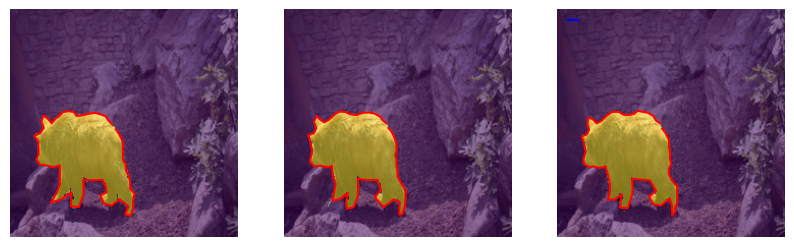

In [22]:
# test the video train dataset
video_idx, frame_idx, first_frame, previous_frame, current_frame = next(
    iter(short_train_loader)
)
fir_img, fir_mask, fir_bou = first_frame
pre_img, pre_mask, pre_bou = previous_frame
cur_img, cur_mask, cur_bou = current_frame
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(normalize(first_frame[0][0]).permute(1, 2, 0))
plt.axis("off")
plt.imshow(first_frame[1][0], alpha=0.5)
plt.plot(first_frame[2][0][:, 0], first_frame[2][0][:, 1], "r")
plt.subplot(1, 3, 2)
plt.imshow(normalize(previous_frame[0][0]).permute(1, 2, 0))
plt.axis("off")
plt.imshow(previous_frame[1][0], alpha=0.5)
plt.plot(previous_frame[2][0][:, 0], previous_frame[2][0][:, 1], "r")
plt.subplot(1, 3, 3)
plt.imshow(normalize(current_frame[0][0]).permute(1, 2, 0))
plt.axis("off")
plt.imshow(current_frame[1][0], alpha=0.5)
plt.plot(current_frame[2][0][:, 0], current_frame[2][0][:, 1], "r")
offset_limit = 10
plt.plot([10, 10 + offset_limit], [10, 10], "b")
plt.show()

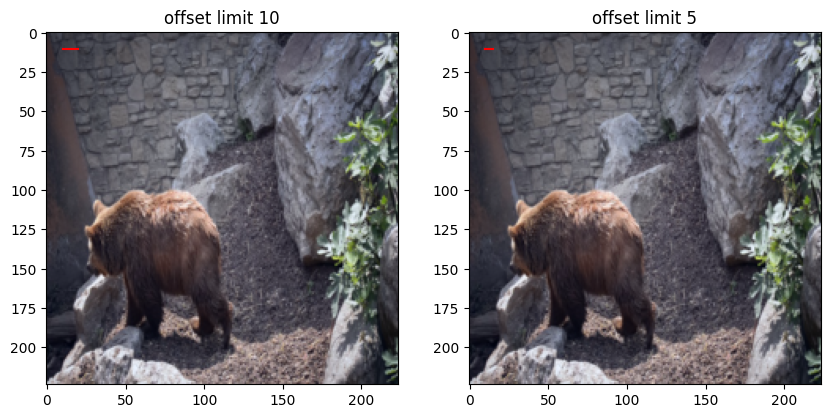

In [24]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(normalize(cur_img[0].permute(1, 2, 0)))
offset_limit = 10
plt.plot([10, 10 + offset_limit], [10, 10], "r")
plt.title("offset limit 10")
plt.subplot(1, 2, 2)
plt.imshow(normalize(cur_img[0].permute(1, 2, 0)))
plt.title("offset limit 5")
offset_limit = 5
plt.plot([10, 10 + offset_limit], [10, 10], "r")
plt.show()

In [45]:
model = DeformLightVideo().cuda()
result = model(
    fir_img.cuda(),
    fir_bou.cuda(),
    pre_img.cuda(),
    pre_bou.cuda(),
    pre_mask.cuda(),
    cur_img.cuda(),
)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


(-0.5, 223.5, 223.5, -0.5)

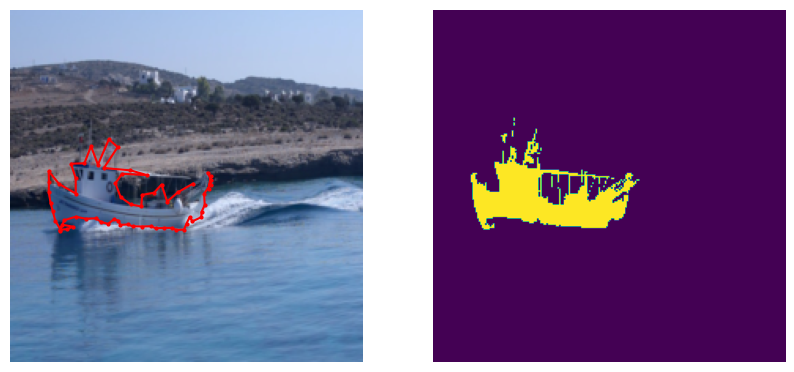

In [49]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(normalize(cur_img[0]).permute(1, 2, 0))
plt.axis('off')
pred_boundary = result[0].detach().cpu().numpy()
plt.plot(pred_boundary[:, 0], pred_boundary[:, 1], "r")
plt.scatter(pred_boundary[:, 0], pred_boundary[:, 1], c="r", s=4)
plt.subplot(1, 2, 2)
plt.imshow(cur_mask[0].detach().cpu().numpy())
plt.axis('off')

In [51]:
len(short_train_loader)

241

In [57]:
ras_loss = RasLoss().cuda()
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()

In [61]:
short_val_inferer = VideoInferer(
    short_val_dataset,
    gt_rasterizer,
)
short_train_inferer = VideoInferer(
    short_train_dataset,
    gt_rasterizer,
)

In [58]:
model = DeformLightVideo().cuda()
loss_dict = {}
train_iou_dict = {}
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epoch_num = 10

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [59]:
for e in range(epoch_num):
    mean_loss = 0
    train_mean_iou = 0
    for (
        video_idx,
        frame_idx,
        first_frame,
        previous_frame,
        current_frame,
    ) in tqdm(short_train_loader):
        optimizer.zero_grad()
        fir_img, fir_mask, fir_bou = first_frame
        pre_img, pre_mask, pre_bou = previous_frame
        cur_img, cur_mask, cur_bou = current_frame
        result = model(
            fir_img.cuda(),
            fir_bou.cuda(),
            pre_img.cuda(),
            pre_bou.cuda(),
            pre_mask.cuda(),
            cur_img.cuda(),
        )
        loss = ras_loss(result, cur_mask.cuda())
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        iou = get_batch_average_bou_iou(
            result,
            cur_mask.cuda(),
            gt_rasterizer,
        )
        train_mean_iou += iou.item()
    mean_loss /= len(short_train_loader)
    train_mean_iou /= len(short_train_loader)
    loss_dict[e] = mean_loss
    train_iou_dict[e] = train_mean_iou
    print(f"Epoch {e} loss: {mean_loss:.4f}, iou: {train_mean_iou:.4f}")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [01:18<00:00,  3.09it/s]


Epoch 0 loss: 0.0989, iou: 0.8334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [01:17<00:00,  3.09it/s]


Epoch 1 loss: 0.0945, iou: 0.8405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [01:17<00:00,  3.09it/s]


Epoch 2 loss: 0.0914, iou: 0.8464


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [01:18<00:00,  3.09it/s]


Epoch 3 loss: 0.0896, iou: 0.8494


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [01:18<00:00,  3.09it/s]


Epoch 4 loss: 0.0865, iou: 0.8546


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [01:18<00:00,  3.09it/s]


Epoch 5 loss: 0.0846, iou: 0.8578


  2%|██▎                                                                                                                                           | 4/241 [00:01<01:53,  2.09it/s]


KeyboardInterrupt: 

In [62]:
short_train_inferer.infer_all_videos(model)

In [ ]:
short_train_inferer.show_video_results(1)

In [2]:
point_path = "sample_results/train_256_uniform.json"
# load the point data
with open(point_path, "r") as f:
    point_data = json.load(f)
type(point_data)

list

In [4]:
type(point_data[0][0])

dict

In [10]:
points_set = []
video_idx = 0
frame_idx = 0
point_nums = [2**i for i in range(2, 8)]
for point_num in point_nums:
    points = point_data[video_idx][frame_idx][str(point_num)]["boundary"]
    points_set.append(points)
point_nums

[4, 8, 16, 32, 64, 128]

In [5]:
class DAVIS_withPointSet(Dataset):
    def __init__(
        self,
        raw_set: DAVIS_Rawset,
        is_train: bool,
        point_nums=[4, 8, 16, 32, 64, 128],
    ) -> None:
        super().__init__()
        # remove all the video with empty frame
        empty_video_idx = []
        for video_idx, video_data in enumerate(raw_set.data_set):
            for frame_data in video_data:
                img, mask = frame_data
                if mask.sum() == 0:
                    empty_video_idx.append(video_idx)
                    break
        self.raw_data_set = []
        if is_train:
            point_path = "sample_results/train_256_uniform.json"
        else:
            point_path = "sample_results/val_256_uniform.json"
        with open(point_path, "r") as f:
            points = json.load(f)

        def get_points(video_idx, frame_idx, point_num):
            return torch.tensor(
                points[video_idx][frame_idx][str(point_num)]["boundary"]
            ).float()
        def get_points_set(video_idx, frame_idx):
            point_set = [get_points(video_idx, frame_idx, point_num) for point_num in point_nums]
            # return torch.nested.nested_tensor(point_set)
            return point_set

        for video_idx, video_data in enumerate(raw_set.data_set):
            if video_idx in empty_video_idx:
                continue
            self.raw_data_set.append([])
            for frame_idx, frame_data in enumerate(video_data):
                img, mask = frame_data
                points_set = get_points_set(video_idx, frame_idx)
                self.raw_data_set[-1].append((img, mask, points_set))
        self.data = []
        for video_idx, video_data in enumerate(self.raw_data_set):
            for frame_idx in range(len(video_data) - 1):
                self.data.append(
                    (
                        video_idx,
                        frame_idx,
                        video_data[0],
                        video_data[frame_idx],
                        video_data[frame_idx + 1],
                    )
                )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        video_idx, frame_idx, first_frame, previous_frame, current_frame = self.data[
            idx
        ]
        return video_idx, frame_idx, first_frame, previous_frame, current_frame

In [6]:
train_point_set_dataset = DAVIS_withPointSet(
    train_rawset,
    is_train=True,
)
val_point_set_dataset = DAVIS_withPointSet(
    val_rawset,
    is_train=False,
)

In [103]:
train_pointset_loader = DataLoader(
    train_point_set_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4,
)
val_pointset_loader = DataLoader(
    val_point_set_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4,
)

In [104]:
# test the point set dataset
video_idx, frame_idx, first_frame, previous_frame, current_frame = next(
    iter(train_pointset_loader)
)

In [105]:
for video_idx, frame_idx, first_frame, previous_frame, current_frame in tqdm(train_pointset_loader):
    pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 7706/7706 [00:51<00:00, 149.79it/s]


In [114]:
fir_img, fir_mask, fir_pointset = first_frame

In [116]:
tmp = fir_pointset[0]
type(tmp), len(tmp), tmp.shape

(torch.Tensor, 1, torch.Size([1, 4, 2]))

In [7]:
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()
val_inferer = VideoInferer(
    val_dataset,
    gt_rasterizer,
)

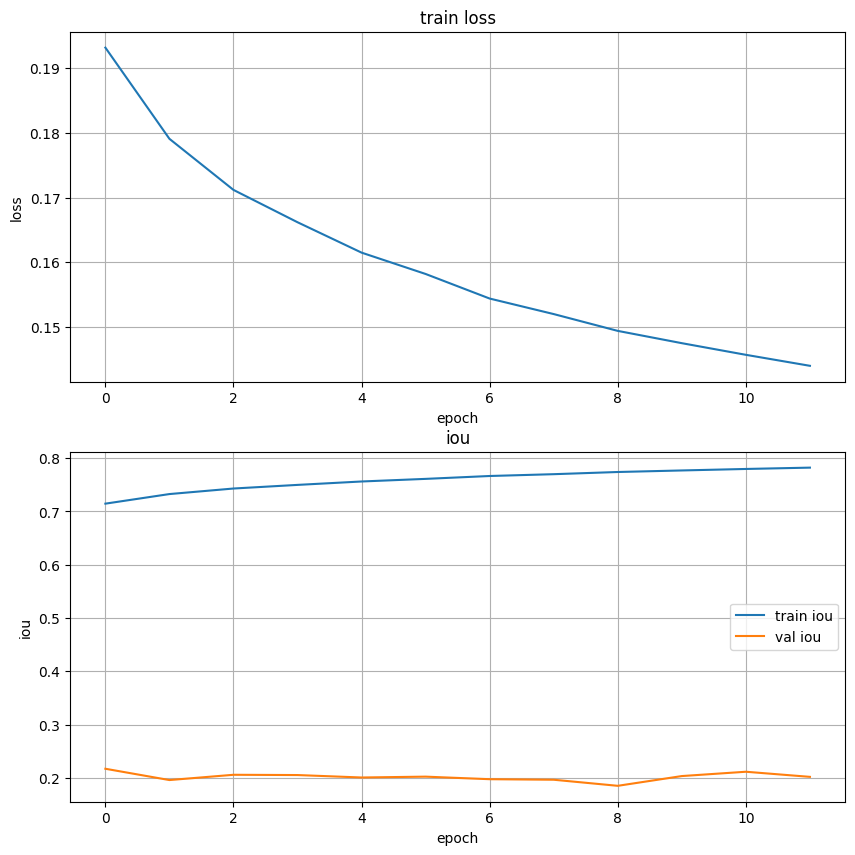

In [23]:
model_name = "def_light_video_5"
# create the log directory
log_dir = f"./log/{model_name}"
log_path = f"{log_dir}/{model_name}.log"
model_path = f"./model/{model_name}_best.pth"
# load the log file
# load the log
with open(log_path, "r") as f:
    logs = f.readlines()
loss_dict = {}
iou_train_dict = {}
iou_val_dict = {}
# get the loss and iou using regex
for log in logs:
    # get the epoch
    epoch = re.search(r"Epoch (\d+)", log)
    if epoch is not None:
        epoch = int(epoch.group(1))
        # get the loss
        loss = re.search(r"train loss: ([\d.]+)", log)
        if loss is not None:
            loss_dict[epoch] = float(loss.group(1))
        # get the train iou
        iou = re.search(r"train iou: ([\d.]+)", log)
        if iou is not None:
            iou_train_dict[epoch] = float(iou.group(1))
        # get the val iou
        iou = re.search(r"val iou: ([\d.]+)", log)
        if iou is not None:
            iou_val_dict[epoch] = float(iou.group(1))
# plot the loss and iou
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(loss_dict.keys(), loss_dict.values())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train loss")
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(iou_train_dict.keys(), iou_train_dict.values(), label="train iou")
plt.plot(iou_val_dict.keys(), iou_val_dict.values(), label="val iou")
plt.xlabel("epoch")
plt.ylabel("iou")
plt.title("iou")
plt.legend()
plt.show()


In [25]:
offset_limit = 5
model = DeformLightVideo(offset_limit=offset_limit).cuda()
model.load_state_dict(torch.load(model_path))

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/tmp/ipykernel_3685408/3592844658.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please 

<All keys matched successfully>

In [26]:
val_inferer.infer_all_videos(model, use_tqdm=True)

  0%|                                                                                                                                                       | 0/57 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [10:35<00:00, 11.14s/it]


In [29]:
val_inferer.compute_all_videos_iou()

0.21722486512771563

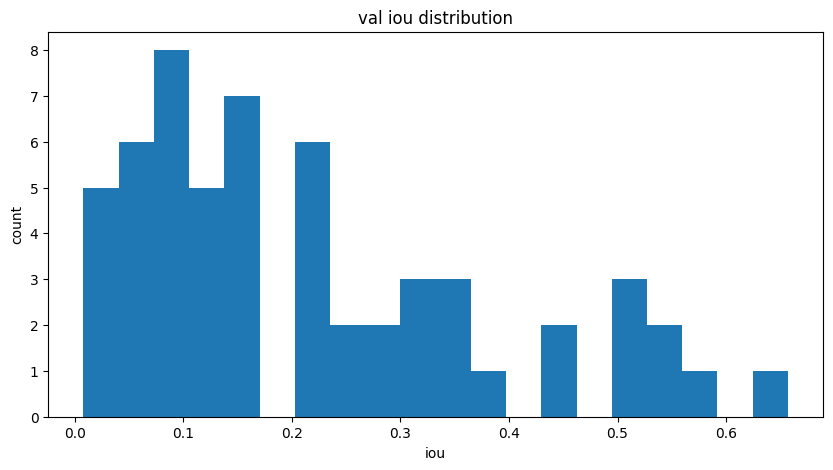

In [30]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 9, 10, 18, 24, 13, 41, 46, 50, 54, 39]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

In [35]:
class IMGPositionEmbeddingSine(nn.Module):
    """
    This is a more standard version of the position embedding, very similar to the one
    used by the Attention is all you need paper, generalized to work on images.
    """

    def __init__(
        self, d_model=384, temperature=10000, normalize=True, scale=None
    ):
        super().__init__()
        self.num_pos_feats = d_model // 2
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        # x = tensor_list.tensors
        # mask = tensor_list.mask
        assert mask is not None
        not_mask = ~mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            eps = 1e-6
            y_embed = (y_embed - 0.5) / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = (x_embed - 0.5) / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack(
            (pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4
        ).flatten(3)
        pos_y = torch.stack(
            (pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4
        ).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos

In [36]:
img_feats = torch.randn(2, 384, 224, 224).cuda()
img_padding_mask = torch.zeros(img_feats.shape[0], img_feats.shape[2], img_feats.shape[3]).bool().cuda()
img_feats.shape, img_padding_mask.shape

(torch.Size([2, 384, 224, 224]), torch.Size([2, 224, 224]))

In [37]:
positional_encoding = IMGPositionEmbeddingSine().cuda()
pos = positional_encoding(img_feats, img_padding_mask)
pos.shape

torch.Size([2, 384, 224, 224])

In [40]:
level_pos = nn.Embedding(5, 384)
level_pos.weight[2].view(1, 1, -1).shape

torch.Size([1, 1, 384])

In [41]:
class DeformLightVideoPos(nn.Module):
    def __init__(
        self,
        layer_num=1,
        head_num=6,
        medium_level_size=[14, 28, 56, 112],
        offset_limit=10,
        n_points=4,
        mem_point_num=64,
        freeze_backbone=True,
    ) -> None:
        super(DeformLightVideoPos, self).__init__()
        self.offset_limit = offset_limit
        self.n_points = n_points
        self.point_num = mem_point_num
        self.medium_level_size = medium_level_size
        self.featup = torch.hub.load(
            "mhamilton723/FeatUp",
            "dino16",
            use_norm=True,
        )
        if freeze_backbone:
            for param in self.featup.parameters():
                param.requires_grad = False
        d_model = 384
        d_ffn = 1024
        n_levels = len(medium_level_size) + 1
        self.pos_enoc = PositionalEncoding(d_model)
        self.level_pos = nn.Embedding(n_levels, d_model)
        self.img_pos = IMGPositionEmbeddingSine(d_model=d_model)
        xavier_uniform_(self.level_pos.weight)

        enc_layer = DeformableTransformerEncoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )
        dec_layer = DeformableTransformerDecoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )

        self.first_query_embed = nn.Embedding(mem_point_num, d_model)
        xavier_uniform_(self.first_query_embed.weight)
        self.first_layer_norm = nn.LayerNorm(d_model)
        self.fir_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        self.fir_dec = DeformableTransformerDecoder(
            dec_layer,
            num_layers=layer_num,
        )
        self.previous_query_embed = nn.Embedding(mem_point_num, d_model)
        xavier_uniform_(self.previous_query_embed.weight)
        self.previous_layer_norm = nn.LayerNorm(d_model)
        self.pre_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        self.pre_dec = DeformableTransformerDecoder(
            dec_layer,
            num_layers=layer_num,
        )
        self.extra_layer_norm = nn.LayerNorm(d_model)

        self.current_query_embed = nn.Embedding(mem_point_num, d_model)
        xavier_uniform_(self.current_query_embed.weight)
        self.current_layer_norm = nn.LayerNorm(d_model)
        self.cur_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        extra_dec_layer = DeformableTransformerExtraDecoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )
        self.cur_dec = DeformableTransformerExtraDecoder(
            extra_dec_layer,
            num_layers=layer_num,
        )
        self.xy_fc = MLP(d_model, d_model, 2, 3)

    def forward(
        self,
        fir_img: torch.Tensor,
        fir_bou: torch.Tensor,
        pre_img: torch.Tensor,
        pre_bou: torch.Tensor,
        pre_sgm: torch.Tensor,
        cur_img: torch.Tensor,
    ):
        fir_bou = fir_bou / 224
        pre_bou = pre_bou / 224
        (
            fir_img_srcs_flatten,
            fir_spatial_shapes,
            fir_level_start_index,
            fir_valid_ratios,
        ) = self._get_enced_img_scrs(
            fir_img,
            self.fir_enc,
            self.first_layer_norm,
        )
        (
            pre_img_srcs_flatten,
            pre_spatial_shapes,
            pre_level_start_index,
            pre_valid_ratios,
        ) = self._get_enced_img_scrs(
            pre_img,
            self.pre_enc,
            self.previous_layer_norm,
        )
        (
            cur_img_srcs_flatten,
            cur_spatial_shapes,
            cur_level_start_index,
            cur_valid_ratios,
        ) = self._get_enced_img_scrs(
            cur_img,
            self.cur_enc,
            self.current_layer_norm,
        )

        B, S, C = fir_img_srcs_flatten.shape
        first_queries = (
            self.first_query_embed.weight.unsqueeze(0).repeat(B, 1, 1).cuda()
        )
        first_memory, _ = self.fir_dec(
            first_queries,
            fir_bou,
            fir_img_srcs_flatten,
            fir_spatial_shapes,
            fir_level_start_index,
            fir_valid_ratios,
        )
        previous_queries = (
            self.previous_query_embed.weight.unsqueeze(0).repeat(B, 1, 1).cuda()
        )
        previous_memory, _ = self.pre_dec(
            previous_queries,
            pre_bou,
            pre_img_srcs_flatten,
            pre_spatial_shapes,
            pre_level_start_index,
            pre_valid_ratios,
        )
        extra_memory = torch.cat([first_memory, previous_memory], 1)
        extra_memory = self.extra_layer_norm(extra_memory)
        extra_memory = self.pos_enoc(extra_memory)

        current_queries = (
            self.current_query_embed.weight.unsqueeze(0).repeat(B, 1, 1).cuda()
        )
        cur_bou = pre_bou
        decode_output, _ = self.cur_dec(
            current_queries,
            cur_bou,
            cur_img_srcs_flatten,
            cur_spatial_shapes,
            cur_level_start_index,
            cur_valid_ratios,
            extra_memory,
        )

        xy_offset = self.xy_fc(decode_output)
        xy_offset = (xy_offset.sigmoid() - 0.5) * self.offset_limit / 224

        result = pre_bou + xy_offset
        result = result * 224
        if not self.training:
            return result.clamp(0, 223)
        return result

    def _get_img_scrs(self, img: torch.Tensor, layernorm: nn.LayerNorm):
        feats = self.featup(img)
        srcs = []
        padding_masks = []
        pos_embeds = []
        for low_res in self.medium_level_size:
            srcs.append(
                F.interpolate(
                    feats,
                    size=(low_res, low_res),
                    mode="bilinear",
                ),
            )
        srcs.append(feats)
        for src in srcs:
            padding_masks.append(torch.zeros_like(src[:, 0:1, :, :]).squeeze(1).bool())
            pos_embeds.append(self.img_pos(src, padding_masks[-1]))
        src_flatten = []
        spatial_shapes = []
        pos_embed_flatten = []
        # for src in srcs:
        # for src, pos in zip(srcs, pos_embeds):
        for lvl, (src, pos) in enumerate(zip(srcs, pos_embeds)):
            src_flatten.append(
                rearrange(src, "b c h w -> b (h w) c"),
            )
            spatial_shapes.append(src.shape[-2:])
            pos = rearrange(pos, "b c h w -> b (h w) c")
            pos = self.level_pos.weight[lvl].view(1, 1, -1) + pos
            pos_embed_flatten.append(pos)

        level_start_index = torch.cat(
            (
                torch.tensor([0]),
                torch.cumsum(
                    torch.tensor([x.shape[1] for x in src_flatten]),
                    0,
                )[:-1],
            )
        ).cuda()
        src_flatten = torch.cat(src_flatten, 1).cuda()
        pos_embed_flatten = torch.cat(pos_embed_flatten, 1).cuda()
        valid_ratios = torch.stack(
            [get_valid_ratio(mask) for mask in padding_masks],
            1,
        ).cuda()
        spatial_shapes = torch.as_tensor(
            spatial_shapes,
            dtype=torch.long,
            device=src_flatten.device,
        )
        src_flatten = layernorm(src_flatten)
        # src_flatten = self.pos_enoc(src_flatten)

        return src_flatten, spatial_shapes, level_start_index, valid_ratios, pos_embed_flatten

    def _get_enced_img_scrs(
        self,
        img: torch.Tensor,
        encoder: DeformableTransformerEncoder,
        layernorm: nn.LayerNorm,
    ):
        src_flatten, spatial_shapes, level_start_index, valid_ratios, pos_embed_flatten = (
            self._get_img_scrs(img, layernorm)
        )
        src_flatten += pos_embed_flatten
        src_flatten = encoder(
            src=src_flatten,
            spatial_shapes=spatial_shapes,
            level_start_index=level_start_index,
            valid_ratios=valid_ratios,
        )
        return src_flatten, spatial_shapes, level_start_index, valid_ratios

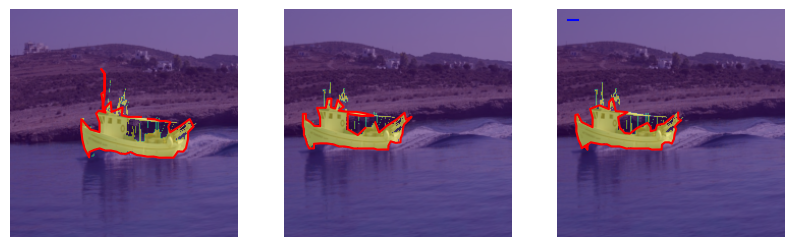

In [53]:
# test the video train dataset
video_idx, frame_idx, first_frame, previous_frame, current_frame = next(
    iter(short_train_loader)
)
fir_img, fir_mask, fir_bou = first_frame
pre_img, pre_mask, pre_bou = previous_frame
cur_img, cur_mask, cur_bou = current_frame
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(normalize(first_frame[0][0]).permute(1, 2, 0))
plt.axis("off")
plt.imshow(first_frame[1][0], alpha=0.5)
plt.plot(first_frame[2][0][:, 0], first_frame[2][0][:, 1], "r")
plt.subplot(1, 3, 2)
plt.imshow(normalize(previous_frame[0][0]).permute(1, 2, 0))
plt.axis("off")
plt.imshow(previous_frame[1][0], alpha=0.5)
plt.plot(previous_frame[2][0][:, 0], previous_frame[2][0][:, 1], "r")
plt.subplot(1, 3, 3)
plt.imshow(normalize(current_frame[0][0]).permute(1, 2, 0))
plt.axis("off")
plt.imshow(current_frame[1][0], alpha=0.5)
plt.plot(current_frame[2][0][:, 0], current_frame[2][0][:, 1], "r")
offset_limit = 10
plt.plot([10, 10 + offset_limit], [10, 10], "b")
plt.show()

In [54]:
model = DeformLightVideoPos(offset_limit=56).cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [58]:
gc.collect()
with torch.no_grad():
    # free the memory
    torch.cuda.empty_cache()

In [59]:
results = model(
    fir_img.cuda(),
    fir_bou.cuda(),
    pre_img.cuda(),
    pre_bou.cuda(),
    pre_mask.cuda(),
    cur_img.cuda(),
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 302.00 MiB. GPU 0 has a total capacity of 31.73 GiB of which 150.69 MiB is free. Process 3627392 has 8.80 GiB memory in use. Including non-PyTorch memory, this process has 22.78 GiB memory in use. Of the allocated memory 21.76 GiB is allocated by PyTorch, and 658.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [50]:
results.shape

torch.Size([2, 64, 2])